### Importing needed packages

In [1]:
import os
import fiona
import folium
import requests
import matplotlib
#import osmnx as ox
import pandas as pd
import geopandas as gpd
import plotly.express as px
from pyproj import Transformer
from folium.plugins import Draw
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from folium.plugins import BeautifyIcon
from sklearn.cluster import MiniBatchKMeans
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.font_manager import FontProperties
from shapely.geometry import Point, LineString, Polygon

### Reading the dataframe of restaurant data

In [2]:
df = pd.read_csv('data/rdata.csv')
df.head()

,_id,BusinessName,RatingValue,AddressLine2,PostCode,Geocode_Longitude,Geocode_Latitude
0,620cd586aa28c13b79512f6f,101 Thai Kitchen,3,London,W6 0RX,-0.244311,51.493618
1,620cd586aa28c13b79512f75,2020 Mezza & Grill,AwaitingInspection,London,W6 9PL,-0.222939,51.488278
2,620cd586aa28c13b79512f78,222 Vegan Restaurant,3,London,W14 9NU,-0.202997,51.485879
3,620cd586aa28c13b79512f7b,24 / 7 Supermarket,3,London,W6 0QU,-0.232831,51.492834
4,620cd586aa28c13b79512f7e,696 Mangal,5,London,SW6 5SA,-0.206834,51.474724


In [3]:
gpd.__version__

'0.10.2'

In [4]:
gdf = gpd.GeoDataFrame(df, geometry= gpd.points_from_xy(df.Geocode_Longitude, df.Geocode_Latitude))
gdf.head()

,_id,BusinessName,RatingValue,AddressLine2,PostCode,Geocode_Longitude,Geocode_Latitude,geometry
0,620cd586aa28c13b79512f6f,101 Thai Kitchen,3,London,W6 0RX,-0.244311,51.493618,POINT (-0.24431 51.49362)
1,620cd586aa28c13b79512f75,2020 Mezza & Grill,AwaitingInspection,London,W6 9PL,-0.222939,51.488278,POINT (-0.22294 51.48828)
2,620cd586aa28c13b79512f78,222 Vegan Restaurant,3,London,W14 9NU,-0.202997,51.485879,POINT (-0.20300 51.48588)
3,620cd586aa28c13b79512f7b,24 / 7 Supermarket,3,London,W6 0QU,-0.232831,51.492834,POINT (-0.23283 51.49283)
4,620cd586aa28c13b79512f7e,696 Mangal,5,London,SW6 5SA,-0.206834,51.474724,POINT (-0.20683 51.47472)


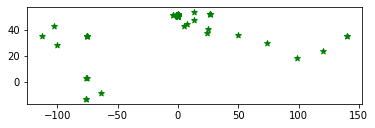

In [5]:
gdf.crs = "EPSG:4326" #Adding crs information to geodataframe
gdf.plot(marker = '*', color = 'green') #Plotting the geodataframe
plt.rcParams['figure.figsize'] = [10, 10] 

<AxesSubplot:>

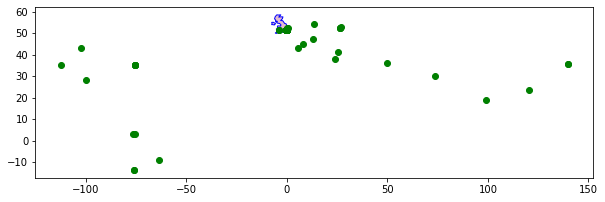

In [6]:
#Loading United Kingdom Data from gpd datasets
# load a sample geodataframe
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  
uk = world[world['name'] == 'United Kingdom']

ax = uk.plot(color ='#e3bccf', edgecolor = 'blue')
plt.rcParams['figure.figsize'] = [10, 10] 

# for x, y, label in zip(uk.geometry.representative_point().x, uk.geometry.representative_point().y, africa_gdf.name):
#     ax.annotate(label, xy=(x, y))
    
gdf.plot(ax=ax, color = 'green')

#### From the plot above it can be seen that not all the points are in London, and will be removed...
#### To do this, we need another dataset that has the London spatial data information, ie London shapefile...

In [7]:
london = gpd.read_file("data/greater_london_const_region.shp")
london.crs #crs here is projected whereas points geodataframe ('gdf') is geographic crs as seen in the next cell

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [8]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
london['geometry'].to_crs(epsg=4326)#, allow_override=True)
london_new = london.to_crs(epsg=4326)#, allow_override=True)
london_new.head()

,NAME,AREA_CODE,DESCRIPTIO,FILE_NAME,NUMBER,NUMBER0,POLYGON_ID,UNIT_ID,CODE,HECTARES,AREA,TYPE_CODE,DESCRIPT0,TYPE_COD0,DESCRIPT1,geometry
0,Havering and Redbridge GL Assembly Const,LAC,Greater London Authority Assembly Constituency,GREATER_LONDON_AUTHORITY,1,1,112074,41452,E32000009,17089.120,215.025,VA,CIVIL VOTING AREA,None,None,"POLYGON ((0.18854 51.48443, 0.18840 51.48445, ..."
1,Croydon and Sutton GL Assembly Const,LAC,Greater London Authority Assembly Constituency,GREATER_LONDON_AUTHORITY,2,2,112056,41443,E32000005,13032.722,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.11139 51.42317, -0.11096 51.42315..."
2,Bexley and Bromley GL Assembly Const,LAC,Greater London Authority Assembly Constituency,GREATER_LONDON_AUTHORITY,3,3,112066,41448,E32000002,21444.201,373.731,VA,CIVIL VOTING AREA,None,None,"POLYGON ((0.15925 51.50871, 0.15994 51.50869, ..."
3,South West GL Assembly Const,LAC,Greater London Authority Assembly Constituency,GREATER_LONDON_AUTHORITY,4,4,112076,41453,E32000013,15259.582,198.064,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.28031 51.50245, -0.28021 51.50237..."
4,Ealing and Hillingdon GL Assembly Const,LAC,Greater London Authority Assembly Constituency,GREATER_LONDON_AUTHORITY,5,5,112054,41442,E32000006,17124.805,0.000,VA,CIVIL VOTING AREA,None,None,"POLYGON ((-0.49463 51.63104, -0.49457 51.63104..."


Breakdown of spatial datasets we have so far...
1. gdf
2. london
3. london_new


In [10]:
london_new.crs #projected coordinate system

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

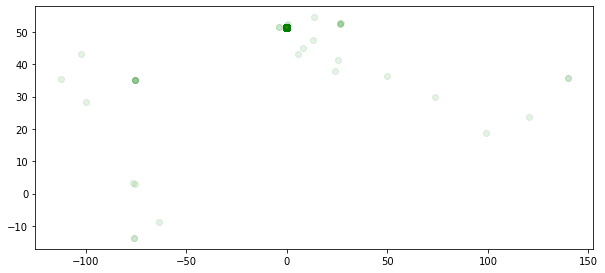

In [11]:
# ax = london.plot()
# gdf.plot(ax=ax)

ax = gdf.plot(alpha=0.1, color='green')
london_new.plot(ax=ax, color = '#C6A619')

#### Plot is not very intuitive, london boundary is shown by a small yellow dot!

<AxesSubplot:>

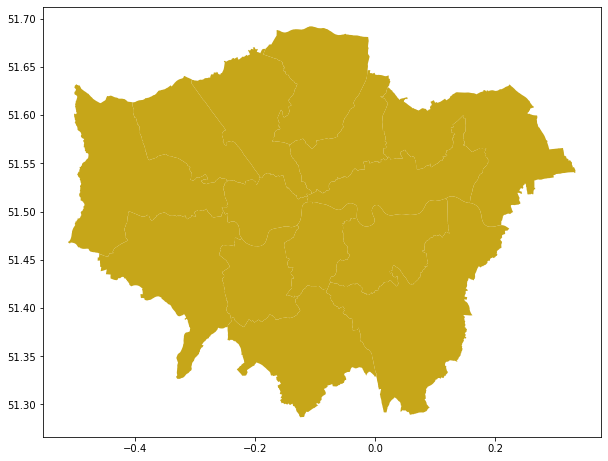

In [12]:
london_new.plot(color='#C6A619')

From the london plot above, it is seen that the highest latitude value is about 51.7 and the lowest value about 51.2
the lowest longitude value is about -0.2 and the highest value about 0.4

In [13]:
to_del = []
long_del_east = gdf[gdf['Geocode_Longitude'] > 0.4].index.to_list()
long_del_west = gdf[gdf['Geocode_Longitude'] <-0.5].index.to_list()
lat_del_upper = gdf[gdf['Geocode_Latitude'] >51.7].index.to_list()
lat_del_lower = gdf[gdf['Geocode_Latitude'] <51.2].index.to_list()

to_del.extend(long_del_east)
to_del.extend(long_del_west)
to_del.extend(lat_del_upper)
to_del.extend(lat_del_lower)
print(len(to_del))
to_del = set(to_del)
print(len(to_del))

62
33


In [14]:
print(f'Before deletion of rows: {len(gdf)}')
gdf = gdf.drop(index=to_del)
print(f'After deletion of rows: {len(gdf)}')

Before deletion of rows: 22288
After deletion of rows: 22255


<AxesSubplot:>

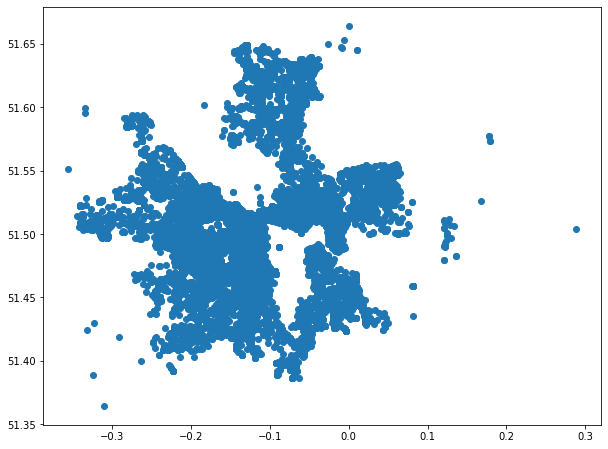

In [15]:
gdf.plot() #looks much better, and within the london area range

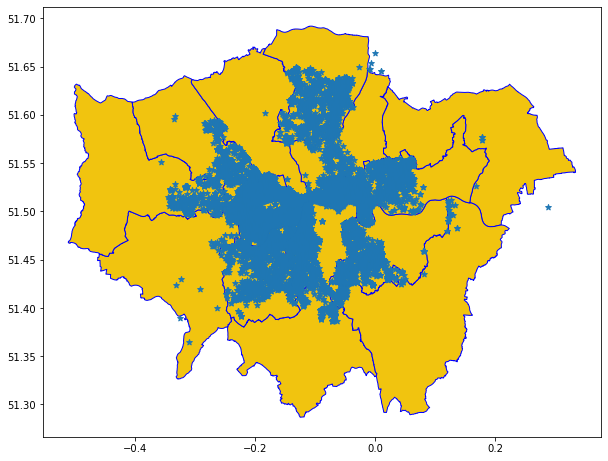

In [16]:
ax = london_new.plot(edgecolor='blue',color='#F1C40F')
gdf.plot(ax=ax, marker='*')
plt.rcParams['figure.figsize']= [8, 8]  #Some points are shown outside the boundary of london but can be ignored for now

### Cluster Analysis 

#### Code for cluster analysis adapted from https://towardsdatascience.com/finding-and-visualizing-clusters-of-geospatial-data-698943c18fed

MiniBatchKMeans?

In [17]:
ssd = []
for i in range(2, 26):
    km = MiniBatchKMeans(n_clusters=i)
    km.fit_predict(gdf[['Geocode_Longitude','Geocode_Latitude']])
    ssd.append(km.inertia_)

Text(0.5, 1.0, 'Elbow method to find the optimal k value')

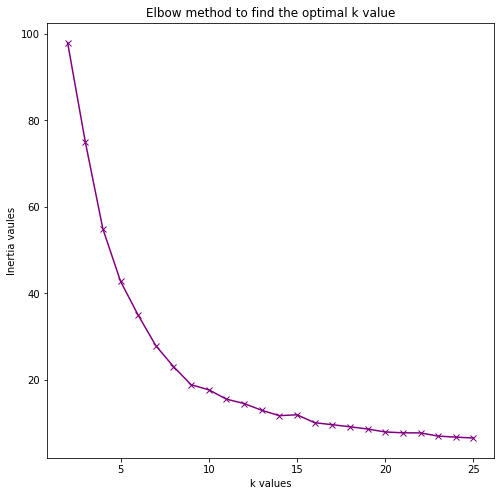

In [18]:
k = range(2, 26)
plt.plot(k, ssd, marker='x', color='purple')
plt.xlabel('k values')
plt.ylabel('Inertia vaules')
plt.title('Elbow method to find the optimal k value')

#### From the plot above we can conclude that the optimal k value is 15 since that is when the inertia values start decreasing linearly

In [22]:
cluster = MiniBatchKMeans(n_clusters=10, random_state=1, verbose=1, )
cluster.fit_predict(gdf[['Geocode_Longitude','Geocode_Latitude']])

Init 1/3 with method k-means++
Inertia for init 1/3: 3.790079369163523
Init 2/3 with method k-means++
Inertia for init 2/3: 3.6358587746736717
Init 3/3 with method k-means++
Inertia for init 3/3: 3.829176065556627
Minibatch step 1/2173: mean batch inertia: 0.0011583980854326203
Minibatch step 2/2173: mean batch inertia: 0.0008387478331218249, ewa inertia: 0.0008387478331218249
Minibatch step 3/2173: mean batch inertia: 0.000816954697624632, ewa inertia: 0.0008367424259732694
Minibatch step 4/2173: mean batch inertia: 0.0008329637329363387, ewa inertia: 0.0008363947101510357
Minibatch step 5/2173: mean batch inertia: 0.0008164876023861423, ewa inertia: 0.0008345628555184646
Minibatch step 6/2173: mean batch inertia: 0.0007730804640827604, ewa inertia: 0.0008289052379025264
Minibatch step 7/2173: mean batch inertia: 0.0007834218070768392, ewa inertia: 0.0008247198467122403
Minibatch step 8/2173: mean batch inertia: 0.0008278303993081266, ewa inertia: 0.0008250060801646296
Minibatch step 

array([0, 0, 0, ..., 5, 5, 5])

In [23]:
cluster.inertia_

17.618697276947906

In [24]:
centers = cluster.cluster_centers_
centers

n_clusters = len(cluster.cluster_centers_)
n_clusters

10

In [25]:
centers_gs = gpd.GeoSeries(map(Point, zip(centers[:,0], centers[:,1])), crs= 'epsg:4326')
centers_gs #coordinates of cluster points

0    POINT (-0.20227 51.51219)
1    POINT (-0.02250 51.46541)
2    POINT (-0.06987 51.52071)
3    POINT (-0.11198 51.43873)
4    POINT (-0.09620 51.60867)
5    POINT (-0.13528 51.50694)
6    POINT (-0.27581 51.53257)
7    POINT (-0.20955 51.44100)
8     POINT (0.03217 51.53332)
9    POINT (-0.16743 51.46246)
dtype: geometry

Text(0.5, 1.0, 'Center points of clusters only')

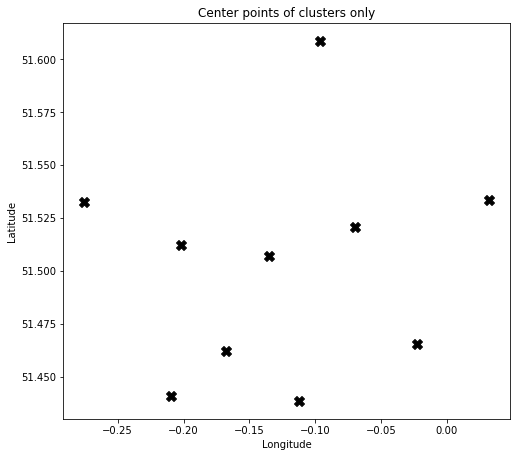

In [26]:
centers_gs.plot(marker='X', color='black', markersize=100) #These are what center points of clusters look like
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Center points of clusters only')

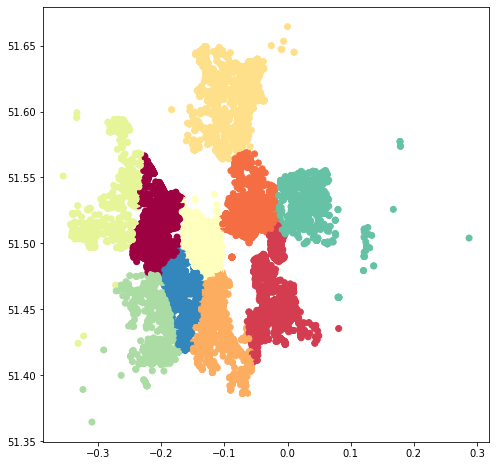

In [27]:
##### clusters are plotted with this function as well(code adapted from https://stackoverflow.com/questions/28227340/kmeans-scatter-plot-plot-different-colors-per-cluster)
plt.scatter(gdf.Geocode_Longitude, gdf.Geocode_Latitude, c=[matplotlib.cm.Spectral(float(i) /10) for i in cluster.labels_]);

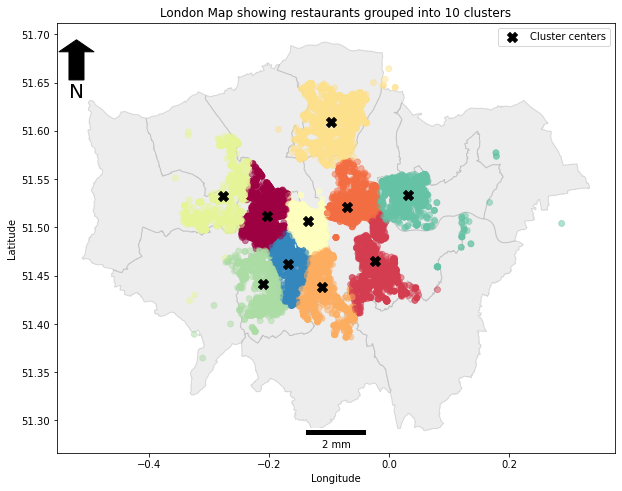

In [28]:
#Plotting London shapefile
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
london_new.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

centers_gs.plot(ax=ax, color='black', marker='X', alpha=1, markersize=100, zorder=3)
gdf.plot(ax=ax, 
         alpha=0.5, 
         c=[matplotlib.cm.Spectral(float(i) /10) for i in cluster.labels_], 
         linewidth=0.8, zorder=2)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#Adding cluster center label to legend
legend_drawn_flag = True
plt.legend(['Cluster centers'], frameon=legend_drawn_flag)

#Adding north arrow
x, y, arrow_length = 0.035, 0.96, 0.12
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=15, headwidth=35),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes) 


#Adding scalebar
scalebar = ScaleBar(2, "cm", length_fraction=0.25, location='lower center')
ax.add_artist(scalebar)   

plt.title('London Map showing restaurants grouped into 10 clusters')
#plt.savefig('imgs/screenshot2.PNG', dpi=300, bbox_inches="tight")

In [27]:
gdf.geometry

0        POINT (-0.24431 51.49362)
1        POINT (-0.22294 51.48828)
2        POINT (-0.20300 51.48588)
3        POINT (-0.23283 51.49283)
4        POINT (-0.20683 51.47472)
                   ...            
22283    POINT (-0.13931 51.50801)
22284    POINT (-0.14351 51.49742)
22285    POINT (-0.14351 51.49742)
22286    POINT (-0.16445 51.49950)
22287    POINT (-0.14351 51.49742)
Name: geometry, Length: 22255, dtype: geometry

### Geopandas and folium plots

Enter name of restaurant: thai
There were 15 thai restaurants found which are shown below in the plot


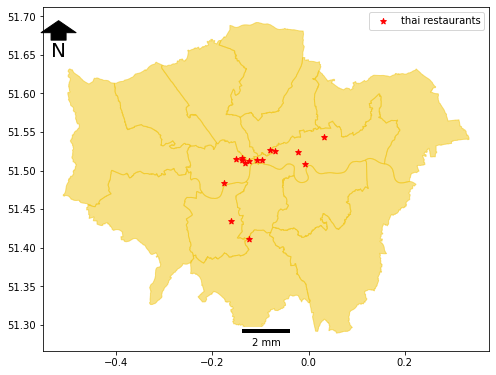

In [28]:
rest_name = input('Enter name of restaurant: ')
rest_name_gdf = gdf[gdf['BusinessName'].str.contains(rest_name)]
if len(rest_name_gdf) == 0:
    print(f'There were {len(rest_name_gdf)} {rest_name} restaurants found.')
else:
    print(f'There were {len(rest_name_gdf)} {rest_name} restaurants found which are shown below in the plot')
    ax = london_new.plot(edgecolor='#F1C40F',color='#F1C40F', alpha=0.5)
    rest_name_gdf.plot(ax=ax, marker='*', color='red')
    legend_drawn_flag = True
    plt.legend([f'{rest_name} restaurants'], frameon=legend_drawn_flag)

    #Adding north arrow
    x, y, arrow_length = 0.035, 0.96, 0.09
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=15, headwidth=35),
                ha='center', va='center', fontsize=20,
                xycoords=ax.transAxes) 


    #Adding scalebar
    scalebar = ScaleBar(2, "cm", length_fraction=0.25, location='lower center')
    ax.add_artist(scalebar) 
    plt.rcParams['figure.figsize']= [8, 8]

map2 = folium.Map(location=[51.51363, -0.09599], tiles="cartodbpositron", zoom_start=10, )
add_markers_to_the_map(map2, rest_name_pjtd, color = 'orange', icon='gg-circle') 

### Buffer plot around point of interest

In [30]:
rest_name_gdf.loc[[2360]].BusinessName

2360    Grabthai Bangkok Cafe
Name: BusinessName, dtype: object

Drawing a buffer of 1000m around Grabthai Bangkok Cafe(our point of interest) to locate other thai restaurants within this area. The best way to visualize this buffer is in folium as it is more interactive...

In [31]:
rest_name_gdf.loc[[2360]].geometry

2360    POINT (-0.09599 51.51363)
Name: geometry, dtype: geometry

<AxesSubplot:>

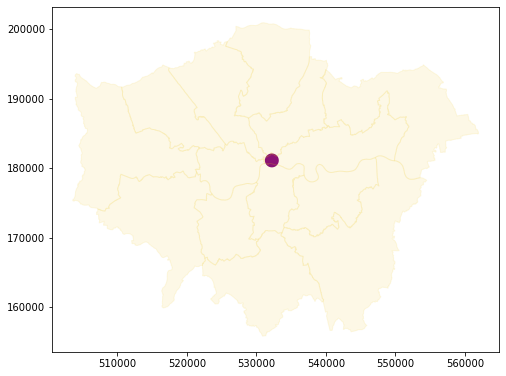

In [32]:
buf1000_gdf = gpd.GeoDataFrame(geometry = rest_name_gdf.loc[[2360]]['geometry'].to_crs('epsg:27700').buffer(1000), 
                           crs='epsg:27700')
ax2 = buf1000_gdf.plot(color='purple')
london.plot(ax=ax2, edgecolor='#F1C40F',color='#F1C40F', alpha=0.1) #using the london gdf as its coordinates are projected

In [33]:
rest_name_gdf.crs #crs is wgs84

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Because buffers and distance calculations are better using projected coordinate system(crs), rest_name_gdf crs must be converted

In [34]:
buf1000_gdf.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

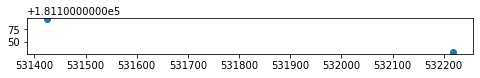

In [35]:
intersection_MeshBlock = gpd.overlay(rest_name_gdf.to_crs('epsg:27700'), 
                                     buf1000_gdf, 
                                     how="intersection")
intersection_MeshBlock.plot()

In [36]:
intersection_MeshBlock

,_id,BusinessName,RatingValue,AddressLine2,PostCode,Geocode_Longitude,Geocode_Latitude,geometry
0,620cd57eaa28c13b7950ba30,Grabthai Bangkok Cafe,4,London,EC4M 9AG,-0.095991,51.513632,POINT (532218.105 181130.058)
1,620cd57eaa28c13b7950ba2d,Grab Food Ltd T/A Grabthai,4,148 Fleet Street,EC4A 2BU,-0.107388,51.514392,POINT (531425.133 181194.059)


rest_name_pjtd = rest_name_gdf.to_crs('epsg:27700')
rest_name_pjtd.head()

### Distance Function

In [37]:
rest_name_gdf.to_crs('epsg:27700').head()

,_id,BusinessName,RatingValue,AddressLine2,PostCode,Geocode_Longitude,Geocode_Latitude,geometry
2360,620cd57eaa28c13b7950ba30,Grabthai Bangkok Cafe,4,London,EC4M 9AG,-0.095991,51.513632,POINT (532218.105 181130.058)
3544,620cd590aa28c13b7951c773,Busaba Eathai,5,LONDON,SW3 5UZ,-0.176735,51.484206,POINT (526697.124 177715.099)
7111,620cd5a5aa28c13b7952f360,Busaba Eathai,3,London,W1F 0AS,-0.137651,51.513151,POINT (529328.860 181002.185)
7112,620cd5a5aa28c13b7952f363,Busaba Eathai,5,London,WC2E 9DA,-0.123613,51.513070,POINT (530303.139 181018.059)
7113,620cd5a5aa28c13b7952f366,Busaba Eathai,2,London,W1W 8ED,-0.138539,51.516376,POINT (529258.121 181359.305)


In [38]:
gdf.head()

,_id,BusinessName,RatingValue,AddressLine2,PostCode,Geocode_Longitude,Geocode_Latitude,geometry
0,620cd586aa28c13b79512f6f,101 Thai Kitchen,3,London,W6 0RX,-0.244311,51.493618,POINT (-0.24431 51.49362)
1,620cd586aa28c13b79512f75,2020 Mezza & Grill,AwaitingInspection,London,W6 9PL,-0.222939,51.488278,POINT (-0.22294 51.48828)
2,620cd586aa28c13b79512f78,222 Vegan Restaurant,3,London,W14 9NU,-0.202997,51.485879,POINT (-0.20300 51.48588)
3,620cd586aa28c13b79512f7b,24 / 7 Supermarket,3,London,W6 0QU,-0.232831,51.492834,POINT (-0.23283 51.49283)
4,620cd586aa28c13b79512f7e,696 Mangal,5,London,SW6 5SA,-0.206834,51.474724,POINT (-0.20683 51.47472)


In [39]:
gdf.to_crs('epsg:27700').head()  

,_id,BusinessName,RatingValue,AddressLine2,PostCode,Geocode_Longitude,Geocode_Latitude,geometry
0,620cd586aa28c13b79512f6f,101 Thai Kitchen,3,London,W6 0RX,-0.244311,51.493618,POINT (521980.141 178647.082)
1,620cd586aa28c13b79512f75,2020 Mezza & Grill,AwaitingInspection,London,W6 9PL,-0.222939,51.488278,POINT (523478.138 178089.047)
2,620cd586aa28c13b79512f78,222 Vegan Restaurant,3,London,W14 9NU,-0.202997,51.485879,POINT (524869.160 177856.062)
3,620cd586aa28c13b79512f7b,24 / 7 Supermarket,3,London,W6 0QU,-0.232831,51.492834,POINT (522779.154 178579.072)
4,620cd586aa28c13b79512f7e,696 Mangal,5,London,SW6 5SA,-0.206834,51.474724,POINT (524633.142 176609.049)


In [40]:
gdf.crs='epsg:4326'
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [41]:
# LineString(coordinates = [gdf.loc[0].geometry, gdf.loc[1].geometry])
# round(gdf.to_crs('epsg:27700').loc[0].geometry.distance(gdf.to_crs('epsg:27700').loc[1].geometry), 3)


In [42]:
a = gdf.loc[[0]]
a
b = gdf.loc[[1]]
b

,_id,BusinessName,RatingValue,AddressLine2,PostCode,Geocode_Longitude,Geocode_Latitude,geometry
1,620cd586aa28c13b79512f75,2020 Mezza & Grill,AwaitingInspection,London,W6 9PL,-0.222939,51.488278,POINT (-0.22294 51.48828)


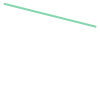

In [43]:
LineString(coordinates = [Point(zip(gdf.loc[[0]].Geocode_Longitude, gdf.loc[[0]].Geocode_Latitude)), Point(zip(gdf.loc[[1]].Geocode_Longitude, gdf.loc[[1]].Geocode_Latitude))])

In [44]:
gdf.crs='epsg:27700'
gdf.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [45]:
def create_linestring_gdf(gdframe, epsg=27700):
    """This function creates a line geodataframe from a point geodataframe"""
    gdframe = gdframe.reset_index(drop=True)
    gdframe = gdframe.drop(["geometry"], axis=1)
    indexes = gdframe.index.to_list()
    crs_info = int(input('What crs information would you like?\n1. WGS84'
                         '\n2. Projected CRS with epsg value passed: '))
    if crs_info == 1:
        linestrings = []
        for i in range(len(indexes)):
            a_lon, a_lat = gdframe.loc[indexes[i-1]].Geocode_Longitude, gdframe.loc[indexes[i-1]].Geocode_Latitude
            b_lon, b_lat = gdframe.loc[indexes[i]].Geocode_Longitude, gdframe.loc[indexes[i]].Geocode_Latitude
            linestrings.append(LineString(coordinates = [Point(a_lat, a_lon), Point(b_lat, b_lon)]))
        gdframe['geometry'] = linestrings                           
    
    elif crs_info == 2:
        linestrings = []
        transformer = Transformer.from_crs(4326, epsg)
        
        for i in range(len(indexes)):
            a_lon, a_lat = gdframe.loc[indexes[i-1]].Geocode_Longitude, gdframe.loc[indexes[i-1]].Geocode_Latitude
            b_lon, b_lat = gdframe.loc[indexes[i]].Geocode_Longitude, gdframe.loc[indexes[i]].Geocode_Latitude
            a_transformed = transformer.transform(a_lat, a_lon)
            b_transformed = transformer.transform(b_lat, b_lon)
            linestrings.append(LineString(coordinates = [Point(a_transformed[0], a_transformed[1]), Point(b_transformed[0], b_transformed[1])]))
        gdframe['geometry'] = linestrings    

        
    return gdframe


def calc_dist_bw_pts_in(gdframe, epsg):
    """Calculates the euclidian distance(saved in a new column called distances) between the previous point and the current point in the point dataframe passed
       First argument that must be passed is the point dataframe
       Second argument that must be passed is the epsg code, since for proper distance calculations, WGS84 coordinates must be converted to projected coordinates"""
    
    gdframe = gdframe.reset_index(drop=True)
    indexes = gdframe.index.to_list()
    distances = []
    option = int(input('Select an option'+
                       '\n1. LineStrings gdf with WGS84 crs'+
                       '\n2. LineString gdf with OSGB(epsg:27700) crs\n'))
    
    if option == 1: #geometry of line gdf must be converted from WGS84 to projected depeding on epsg that the user passes
        for i in range(len(indexes)):
            distances.append(round(gdframe.to_crs(f'epsg:{epsg}').loc[indexes[i-1]].geometry.distance(gdframe.to_crs(f'epsg:{epsg}').loc[indexes[i]].geometry), 2))                  
        gdframe['distances']=distances                    

    elif option == 2:
        for i in range(len(indexes)):
            distances.append(round(gdframe.loc[i]['geometry'].length, 2))                 
        gdframe['distances']=distances  
    
    return gdframe

In [46]:
line = create_linestring_gdf(intersection_MeshBlock)
line = calc_dist_bw_pts_in(line, epsg=27700)
line

What crs information would you like?
1. WGS84
2. Projected CRS with epsg value passed: 2
Select an option
1. LineStrings gdf with WGS84 crs
2. LineString gdf with OSGB(epsg:27700) crs
2


,_id,BusinessName,RatingValue,AddressLine2,PostCode,Geocode_Longitude,Geocode_Latitude,geometry,distances
0,620cd57eaa28c13b7950ba30,Grabthai Bangkok Cafe,4,London,EC4M 9AG,-0.095991,51.513632,"LINESTRING (531425.133 181194.059, 532218.105 ...",795.55
1,620cd57eaa28c13b7950ba2d,Grab Food Ltd T/A Grabthai,4,148 Fleet Street,EC4A 2BU,-0.107388,51.514392,"LINESTRING (532218.105 181130.058, 531425.133 ...",795.55


In [47]:
intersection_MeshBlock

,_id,BusinessName,RatingValue,AddressLine2,PostCode,Geocode_Longitude,Geocode_Latitude,geometry
0,620cd57eaa28c13b7950ba30,Grabthai Bangkok Cafe,4,London,EC4M 9AG,-0.095991,51.513632,POINT (532218.105 181130.058)
1,620cd57eaa28c13b7950ba2d,Grab Food Ltd T/A Grabthai,4,148 Fleet Street,EC4A 2BU,-0.107388,51.514392,POINT (531425.133 181194.059)


In [48]:
line

,_id,BusinessName,RatingValue,AddressLine2,PostCode,Geocode_Longitude,Geocode_Latitude,geometry,distances
0,620cd57eaa28c13b7950ba30,Grabthai Bangkok Cafe,4,London,EC4M 9AG,-0.095991,51.513632,"LINESTRING (531425.133 181194.059, 532218.105 ...",795.55
1,620cd57eaa28c13b7950ba2d,Grab Food Ltd T/A Grabthai,4,148 Fleet Street,EC4A 2BU,-0.107388,51.514392,"LINESTRING (532218.105 181130.058, 531425.133 ...",795.55


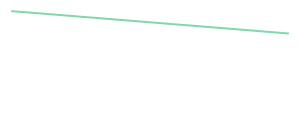

In [49]:
line.loc[1]['geometry']

In [50]:
line.loc[0]

_id                                           620cd57eaa28c13b7950ba30
BusinessName                                     Grabthai Bangkok Cafe
RatingValue                                                          4
AddressLine2                                                    London
PostCode                                                      EC4M 9AG
Geocode_Longitude                                            -0.095991
Geocode_Latitude                                               51.5136
geometry             LINESTRING (531425.1327309737 181194.059220527...
distances                                                       795.55
Name: 0, dtype: object

line.plot?

<AxesSubplot:>

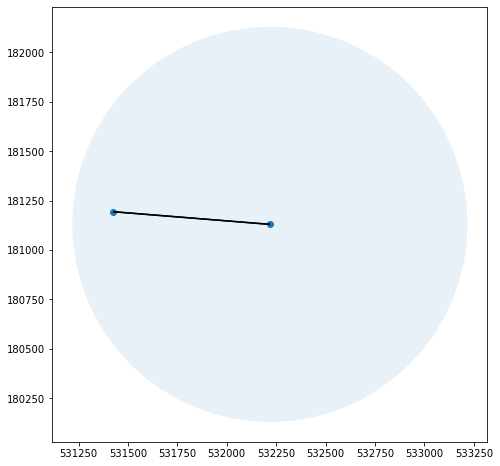

In [51]:
ax3 = buf1000_gdf.plot(alpha=0.1)
intersection_MeshBlock.plot(ax=ax3)
line.plot(ax=ax3, color='black', legend=True)
# legend_drawn_flag = True
# plt.legend(['Euclidean distance'], frameon=legend_drawn_flag)

In [52]:
buf1000_gdf.geometry.centroid ##returns the centroid

2360    POINT (532218.105 181130.058)
dtype: geometry

In [53]:
# rest_name_gdf
# restaurants = rest_name_gdf['geometry'].to_json()
# restaurants = folium.features.GeoJson(restaurants)
# my_map.add_child(restaurants)
# my_map 
my_map = folium.Map(location=[51.5074, 0.1272], tiles="OpenStreetMap", zoom_start=11,)
def add_markers_to_the_map(map_object, gdf, color, icon=None):  
    points = list(zip(zip(gdf.Geocode_Latitude, gdf.Geocode_Longitude),
                      gdf.BusinessName, 
                      gdf.RatingValue, 
                      gdf.PostCode))
    for point in points:         
            html =f"Name: {point[1]} <br>RatingValue: {str(point[2])} <br>PostCode: {point[3]}"
        
#           popup = folium.Popup(popup_text, autopan='False', parse_html=True, max_width=500)
            
            iframe= folium.IFrame(html)
            popup = folium.Popup(iframe,
                    min_width=250, 
                    max_width=250, 
                    parse_html=True)
            
            marker = folium.Marker(location=point[0], 
                                   popup=popup).add_to(map_object)
    return map_object

add_markers_to_the_map(my_map, rest_name_gdf, color = 'black', icon='gg-circle')

buf_1000m = folium.Circle(location=[rest_name_gdf.loc[2360].Geocode_Latitude, 
               rest_name_gdf.loc[2360].Geocode_Longitude], 
               radius=1000, #1000m radius
               color='green', 
               fill=True, 
               opacity=0.1,
               fill_opacity=0.6)
buf_1000m.add_to(my_map)

buf_4000m = folium.Circle(location=[rest_name_gdf.loc[2360].Geocode_Latitude, 
               rest_name_gdf.loc[2360].Geocode_Longitude], 
               radius=4000, #1000m radius
               color='yellow', 
               fill=True, 
               opacity=0.1,
               fill_opacity=0.4)
buf_4000m.add_to(my_map)

folium.PolyLine(locations=[(line.loc[0].Geocode_Latitude, line.loc[0].Geocode_Longitude), 
                           (line.loc[1].Geocode_Latitude, line.loc[1].Geocode_Longitude)], 
                tooltip=f"{round(line.loc[[0]].distances[0],2)}").add_to(my_map)

my_map #we can see the restaurants within our area of interest, together with thwir popups

#### Finding the distances between all points in 'buf_4000m'(the yellow buffered area in the folium plot above)
#### What will be done
- 1. Gdf containing the intersection of the the yellow buffered area and the points that fall within that area, will be created
- 2. The line gdf is created from the point gdf in step1
- 3. The euclidean distances between all points in the gdf will be calculated using the function created above (calc_dist_bw_pts_in)
- 4. It is finally plotted on the folium plot

In [54]:
buf_4000m

<AxesSubplot:>

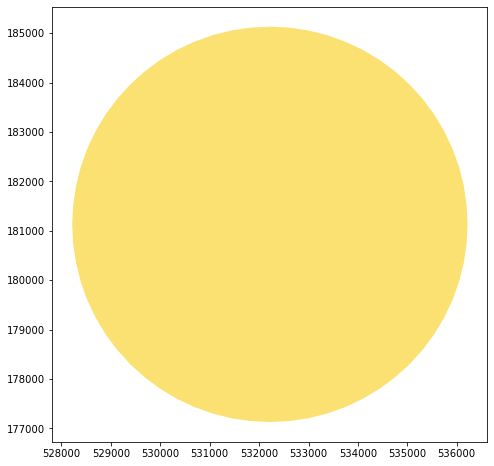

In [55]:
buf4000_gdf = gpd.GeoDataFrame(geometry = rest_name_gdf.loc[[2360]]['geometry'].to_crs('epsg:27700').buffer(4000), 
                           crs='epsg:27700')
buf4000_gdf.plot(color='#F9D742', alpha=0.75)

<AxesSubplot:>

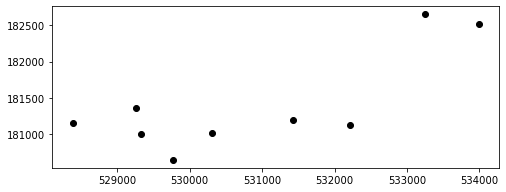

In [56]:
intersectn_restgdf_400buf = gpd.overlay(rest_name_gdf.to_crs('epsg:27700'), 
                                     buf4000_gdf, 
                                     how="intersection")
intersectn_restgdf_400buf.plot(color='black')

In [57]:
points_in_400m_buf = create_linestring_gdf(intersectn_restgdf_400buf)
points_in_400m_buf

What crs information would you like?
1. WGS84
2. Projected CRS with epsg value passed: 2


,_id,BusinessName,RatingValue,AddressLine2,PostCode,Geocode_Longitude,Geocode_Latitude,geometry
0,620cd57eaa28c13b7950ba30,Grabthai Bangkok Cafe,4,London,EC4M 9AG,-0.095991,51.513632,"LINESTRING (529772.755 180635.207, 532218.105 ..."
1,620cd5a5aa28c13b7952f360,Busaba Eathai,3,London,W1F 0AS,-0.137651,51.513151,"LINESTRING (532218.105 181130.058, 529328.860 ..."
2,620cd5a5aa28c13b7952f363,Busaba Eathai,5,London,WC2E 9DA,-0.123613,51.513070,"LINESTRING (529328.860 181002.185, 530303.139 ..."
3,620cd5a5aa28c13b7952f366,Busaba Eathai,2,London,W1W 8ED,-0.138539,51.516376,"LINESTRING (530303.139 181018.059, 529258.121 ..."
4,620cd5a5aa28c13b7952f369,Busaba Eathai,5,London,W1U 1BU,-0.151189,51.514713,"LINESTRING (529258.121 181359.305, 528385.116 ..."
5,620cd57eaa28c13b7950ba2d,Grab Food Ltd T/A Grabthai,4,148 Fleet Street,EC4A 2BU,-0.107388,51.514392,"LINESTRING (528385.116 181152.068, 531425.133 ..."
6,620cd585aa28c13b79511a21,Busaba Eathai Ltd,5,313-319 Old Street,EC1V 9LE,-0.080650,51.527141,"LINESTRING (531425.133 181194.059, 533243.143 ..."
7,620cd59faa28c13b7952a25d,Busaba Eathai Ltd,5,3 Innova Passage/36 Bethnal Green Road,E1 6LJ,-0.069962,51.525646,"LINESTRING (533243.143 182660.104, 533988.913 ..."
8,620cd5a5aa28c13b7952f36c,Busaba Eathai,5,32-34 Panton Street,SW1Y 4EA,-0.131393,51.509751,"LINESTRING (533988.913 182513.303, 529772.755 ..."


In [59]:
lines_in400m_buf = calc_dist_bw_pts_in(points_in_400m_buf, epsg=27700)
lines_in400m_buf

Select an option
1. LineStrings gdf with WGS84 crs
2. LineString gdf with OSGB(epsg:27700) crs
2


,_id,BusinessName,RatingValue,AddressLine2,PostCode,Geocode_Longitude,Geocode_Latitude,geometry,distances
0,620cd57eaa28c13b7950ba30,Grabthai Bangkok Cafe,4,London,EC4M 9AG,-0.095991,51.513632,"LINESTRING (529772.755 180635.207, 532218.105 ...",2494.92
1,620cd5a5aa28c13b7952f360,Busaba Eathai,3,London,W1F 0AS,-0.137651,51.513151,"LINESTRING (532218.105 181130.058, 529328.860 ...",2892.07
2,620cd5a5aa28c13b7952f363,Busaba Eathai,5,London,WC2E 9DA,-0.123613,51.513070,"LINESTRING (529328.860 181002.185, 530303.139 ...",974.41
3,620cd5a5aa28c13b7952f366,Busaba Eathai,2,London,W1W 8ED,-0.138539,51.516376,"LINESTRING (530303.139 181018.059, 529258.121 ...",1099.32
4,620cd5a5aa28c13b7952f369,Busaba Eathai,5,London,W1U 1BU,-0.151189,51.514713,"LINESTRING (529258.121 181359.305, 528385.116 ...",897.27
5,620cd57eaa28c13b7950ba2d,Grab Food Ltd T/A Grabthai,4,148 Fleet Street,EC4A 2BU,-0.107388,51.514392,"LINESTRING (528385.116 181152.068, 531425.133 ...",3040.31
6,620cd585aa28c13b79511a21,Busaba Eathai Ltd,5,313-319 Old Street,EC1V 9LE,-0.080650,51.527141,"LINESTRING (531425.133 181194.059, 533243.143 ...",2335.48
7,620cd59faa28c13b7952a25d,Busaba Eathai Ltd,5,3 Innova Passage/36 Bethnal Green Road,E1 6LJ,-0.069962,51.525646,"LINESTRING (533243.143 182660.104, 533988.913 ...",760.08
8,620cd5a5aa28c13b7952f36c,Busaba Eathai,5,32-34 Panton Street,SW1Y 4EA,-0.131393,51.509751,"LINESTRING (533988.913 182513.303, 529772.755 ...",4615.54


<AxesSubplot:>

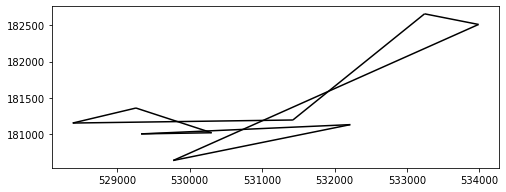

In [60]:
lines_in400m_buf.plot(color='black')

In [61]:
# rest_name_gdf
# restaurants = rest_name_gdf['geometry'].to_json()
# restaurants = folium.features.GeoJson(restaurants)
# my_map.add_child(restaurants)
# my_map 
#functions

def add_markers_to_the_map(map_object, gdf, colour, icon=None):  
    """Takes map_object(folium map), geodataframe, colour and icon and creates a improved folium map 
       with additional features(popups at the locations in the geodataframe with colour passed)"""
    points = list(zip(zip(gdf.Geocode_Latitude, gdf.Geocode_Longitude),
                      gdf.BusinessName, 
                      gdf.RatingValue, 
                      gdf.PostCode))
    for point in points:         
            html =f"Name: {point[1]} <br>RatingValue: {str(point[2])} <br>PostCode: {point[3]}"
#           popup = folium.Popup(popup_text, autopan='False', parse_html=True, max_width=500)
            
            iframe= folium.IFrame(html)
            popup = folium.Popup(iframe,
                    min_width=250, 
                    max_width=250, 
                    parse_html=True)
            
            marker = folium.Marker(location=point[0], 
                                   popup=popup, 
                                   #icon=folium.Icon(icon_size=(25, 25), color=colour, icon=icon, prefix='fa')).add_to(map_object)
                                  ).add_to(map_object)
    return map_object

def add_lines_to(map_object, line_gdf, color):
    """Takes folim  map and line geodataframe and adds line plot on folium map with their corresponding distances shown on tooltp"""
    indexes = line_gdf.index.to_list()
    for i in range(len(indexes)):
        loc = [(line_gdf.loc[indexes[i-1]].Geocode_Latitude, line_gdf.loc[indexes[i-1]].Geocode_Longitude), 
               (line_gdf.loc[indexes[i]].Geocode_Latitude, line_gdf.loc[indexes[i]].Geocode_Longitude)]
        folium.PolyLine(locations=loc, color=color,
                        tooltip=line_gdf.loc[[i]].distances[i]).add_to(map_object)
    return map_object
    
my_map = folium.Map(location=[51.5074, 0.1272], tiles="OpenStreetMap", zoom_start=11,)
add_markers_to_the_map(my_map, rest_name_gdf, colour = 'black', icon=None) #calling the function

buf_1000m = folium.Circle(location=[rest_name_gdf.loc[2360].Geocode_Latitude, 
               rest_name_gdf.loc[2360].Geocode_Longitude], 
               radius=1000, #1000m radius
               color='green', 
               fill=True, 
               opacity=0.1,
               fill_opacity=0.6)
buf_1000m.add_to(my_map)

buf_4000m = folium.Circle(location=[rest_name_gdf.loc[2360].Geocode_Latitude, 
               rest_name_gdf.loc[2360].Geocode_Longitude], 
               radius=4000, #1000m radius
               color='yellow', 
               fill=True, 
               opacity=0.1,
               fill_opacity=0.4)
buf_4000m.add_to(my_map)

add_lines_to(my_map, line, color='red')
add_lines_to(my_map, lines_in400m_buf, 'black')

draw = Draw()
draw.add_to(my_map)  #This gives the user the opportunity to draw on the map
folium.LayerControl(collapsed=False).add_to(my_map)
my_map
# my_map #we can see the restaurants within our area of interest, together with lines connecting them and their popups

In [60]:
folium.Icon?

#### Alternatively,  the Draw function in folium has extra tools to calculate the distances between point, which is a simplification of the custom functions(create_linestring_gdf & calc_dist_bw_pts_in) created

#### Adding a convex hull to the plot to show the border of the region of interest

#### convex hull code adapted from https://fcpython.com/visualisation/convex-hulls-football-python

In [62]:
hull = ConvexHull(rest_name_gdf[['Geocode_Longitude','Geocode_Latitude']])
hull

<AxesSubplot:>

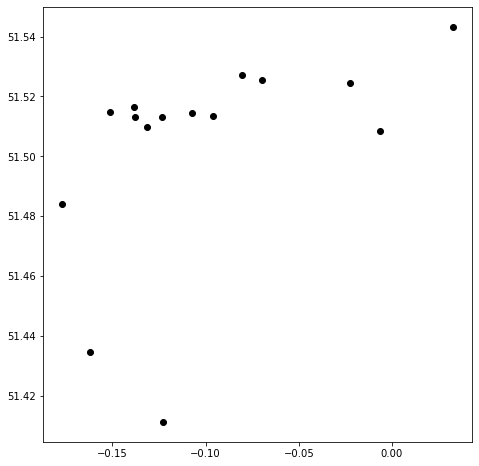

In [63]:
rest_name_gdf.plot(color='black')

In [64]:
rest_name_gdf.iloc[5]['Geocode_Longitude'], rest_name_gdf.iloc[5]['Geocode_Latitude']

(-0.15118900000000002, 51.514713)

In [65]:
hull.vertices

array([ 5,  1, 13,  6, 10,  9,  8], dtype=int32)

[[(51.514713, -0.15118900000000002), (51.484206, -0.176735)],
 [(51.434670000000004, -0.16203199999999998), (51.484206, -0.176735)],
 [(51.434670000000004, -0.16203199999999998), (51.4112536, -0.1229287)],
 [(51.508528999999996, -0.006439), (51.543299, 0.032606)],
 [(51.508528999999996, -0.006439), (51.4112536, -0.1229287)],
 [(51.527141, -0.08065), (51.543299, 0.032606)],
 [(51.527141, -0.08065), (51.514713, -0.15118900000000002)]]

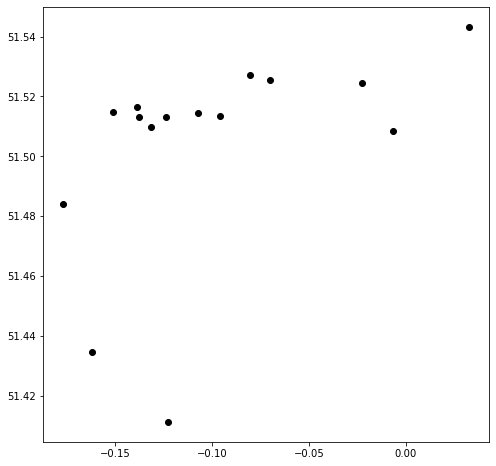

In [66]:
plt.plot(rest_name_gdf.Geocode_Longitude, rest_name_gdf.Geocode_Latitude, 'o', color='black')

#Loop through each of the hull's simplices
linepts = []
for simplex in hull.simplices:
    #Draw a black line between each
    linepts.append([(rest_name_gdf.iloc[simplex[0]]['Geocode_Latitude'], rest_name_gdf.iloc[simplex[0]]['Geocode_Longitude']), (rest_name_gdf.iloc[simplex[1]]['Geocode_Latitude'], rest_name_gdf.iloc[simplex[1]]['Geocode_Longitude'])])

    
linepts

In [67]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))  #adapted from https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates

folium.PolyLine?

In [69]:
for x in linepts:
       folium.PolyLine(locations=x).add_to(my_map)

In [70]:
my_map

### London Transport data -Tube

In [71]:
pd.read_csv('data/bus-stops-example.csv')

,Stop_Code_LBSL,Bus_Stop_Code,Naptan_Atco,Stop_Name,Location_Easting,Location_Northing,Heading,Stop_Area,Virtual_Bus_Stop
0,10001,72689,490013793E,TREVOR CLOSE,515781,174783,78,NB16,0
1,10002,48461,490000108F,HIGHBURY CORNER,531614,184603,5,C902,0
2,10003,77150,490000108B,HIGHBURY & ISLINGTON STATION <> #,531573,184786,127,C903,0
3,10004,48037,490012451S,ST MARY MAGDALENE CHURCH,531403,184942,136,C904,0
4,10005,57538,490012451N,ST MARY MAGDALENE CHURCH,531328,185009,322,C904,0
...,...,...,...,...,...,...,...,...,...
194,10880,53256,490010736G,PALMERS GREEN / THE TRIANGLE,530996,192606,6,U605,0
195,10881,47221,490009248C,LODGE DRIVE,531110,192821,26,U606,0
196,10883,75172,490006974A,FOX LANE,531172,192966,19,U607,0
197,10885,71425,490006974Z,FOX LANE,531220,193067,199,U607,0


url = 'https://api.tfl.gov.uk/Line/victoria/' #'https://api.tfl.gov.uk/Line/Mode/tube'
response = requests.request("GET", url)
print(response.text)

### Using osmnx to obtain london network graph data

ox.graph_from_place?

place = ['London']
G = ox.graph_from_place(place, retain_all=True, simplify = True, network_type='all')

fig, ax = ox.plot_graph(G, node_size=0, 
                        dpi = 100,bgcolor = bgcolor,
                        save = False, edge_color=roadCols,
                        edge_linewidth=1, edge_alpha=1)

---------

### Reading london tube data downloaded from https://www.doogal.co.uk/london_stations

In [72]:
tube_df = pd.read_csv('data/London_tube_lines.csv')
tube_df.head()

,Tube Line,From Station,To Station
0,Bakerloo,Baker Street,Regents Park
1,Bakerloo,Charing Cross,Embankment
2,Bakerloo,Edgware Road (Bakerloo),Marylebone
3,Bakerloo,Embankment,Waterloo
4,Bakerloo,Harlesden,Willesden Junction


In [73]:
# gpd.read_file('London_Train_Lines.kml')

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
tube_linesgdf = gpd.read_file('data/London_Train_Lines.kml', driver='KML')
tube_linesgdf.head()

,Name,Description,geometry
0,Bakerloo - Baker Street to Regents Park,,"LINESTRING Z (-0.15690 51.52313 1.00000, -0.14..."
1,Bakerloo - Charing Cross to Embankment,,"LINESTRING Z (-0.12480 51.50836 1.00000, -0.12..."
2,Bakerloo - Edgware Road (Bakerloo) to Marylebone,,"LINESTRING Z (-0.17054 51.52065 1.00000, -0.16..."
3,Bakerloo - Embankment to Waterloo,,"LINESTRING Z (-0.12237 51.50731 1.00000, -0.11..."
4,Bakerloo - Harlesden to Willesden Junction,,"LINESTRING Z (-0.25750 51.53626 1.00000, -0.24..."


In [74]:
# gpd.read_file('London_Train_Lines.kml')

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
tube_stnsgdf = gpd.read_file('data/london_tube_stations.kml', driver='KML')
tube_stnsgdf.head()

,Name,Description,geometry
0,Abbey Road,<div>Zone 3</div> <div>E15 3NB</div> <div>Lati...,POINT Z (0.00372 51.53195 0.00000)
1,Abbey Wood,<div>Zone 4</div> <div>SE2 9RH</div> <div>Lati...,POINT Z (0.12027 51.49078 0.00000)
2,Acton Central,<div>Zone 2</div> <div>W3 6BH</div> <div>Latit...,POINT Z (-0.26343 51.50876 0.00000)
3,Acton Main Line,<div>Zone 3</div> <div>W3 9EH</div> <div>Latit...,POINT Z (-0.26769 51.51689 0.00000)
4,Acton Town,<div>Zone 3</div> <div>W3 8HN</div> <div>Latit...,POINT Z (-0.28030 51.50307 0.00000)


In [75]:
[i for i in tube_linesgdf.loc[[0]].geometry[0].coords]

[(-0.15690419298618452, 51.52312936605881, 1.0),
 (-0.1453444097205957, 51.523810437772845, 1.0)]

Text(0.5, 1.0, 'London tube lines')

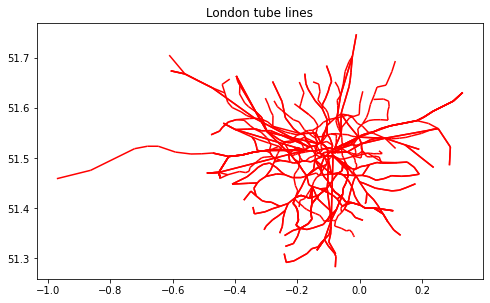

In [76]:
tube_linesgdf.plot(color='red')
plt.title('London tube lines')

In [77]:
#showing what the tube lines look like in the real world
tube_linesgdf.explore(color='red')  #if explore doesn't run update version of geopandas

In [78]:
gpd.__version__

'0.10.2'

#### Obtaining from and to locations from tube lines to be added to a folium feature group

[list(tube_linesgdf.apply(lambda row: row.loc[[i for i in tube_linesgdf['indexx']]]).geometry[index_no].coords) for index_no in tube_linesgdf.index]


In [79]:
tube_stnsgdf.explore(color='red')  #showing what the points look like in the real world

In [80]:
tube_stnsgdf.columns

Index(['Name', 'Description', 'geometry'], dtype='object')

### Connecting London tube lines and station points with restaurant data so that layers can be visualized

#### Creating and adding a feature group made of tube lines

In [81]:
tube_linesgdf.head()

,Name,Description,geometry
0,Bakerloo - Baker Street to Regents Park,,"LINESTRING Z (-0.15690 51.52313 1.00000, -0.14..."
1,Bakerloo - Charing Cross to Embankment,,"LINESTRING Z (-0.12480 51.50836 1.00000, -0.12..."
2,Bakerloo - Edgware Road (Bakerloo) to Marylebone,,"LINESTRING Z (-0.17054 51.52065 1.00000, -0.16..."
3,Bakerloo - Embankment to Waterloo,,"LINESTRING Z (-0.12237 51.50731 1.00000, -0.11..."
4,Bakerloo - Harlesden to Willesden Junction,,"LINESTRING Z (-0.25750 51.53626 1.00000, -0.24..."


for idx, pt in enumerate([list(tube_linesgdf.geometry[index_no].coords) for index_no in tube_linesgdf.index]):
    print(tube_linesgdf.loc[idx]['Name'])

fg1 = folium.FeatureGroup(name='Tube', overlay=False, control=True)
for idx, pt in enumerate([list(tube_linesgdf.geometry[index_no].coords) for index_no in tube_linesgdf.index]):
    location = [pt[0][:2][::-1], pt[1][:2][::-1]] #obtaining only long, lat
    fg1.add_child(folium.PolyLine(location, color='red', tooltip=tube_linesgdf.loc[idx]['Name']))
    fg1.add_to(my_map)

#my_map.add_child(fg1)
# themap.save('map.html')

# base_map = folium.FeatureGroup(name='Basemap', overlay=True, control=False)
# folium.TileLayer(tiles='OpenStreetMap').add_to(base_map)


#folium.LayerControl(collapsed=False).add_to(my_map)
my_map.add_child(folium.LayerControl(collapsed=False))
my_map

#### Creating and adding a feature group made of tube stations

In [82]:
tube_stnsgdf.head()

,Name,Description,geometry
0,Abbey Road,<div>Zone 3</div> <div>E15 3NB</div> <div>Lati...,POINT Z (0.00372 51.53195 0.00000)
1,Abbey Wood,<div>Zone 4</div> <div>SE2 9RH</div> <div>Lati...,POINT Z (0.12027 51.49078 0.00000)
2,Acton Central,<div>Zone 2</div> <div>W3 6BH</div> <div>Latit...,POINT Z (-0.26343 51.50876 0.00000)
3,Acton Main Line,<div>Zone 3</div> <div>W3 9EH</div> <div>Latit...,POINT Z (-0.26769 51.51689 0.00000)
4,Acton Town,<div>Zone 3</div> <div>W3 8HN</div> <div>Latit...,POINT Z (-0.28030 51.50307 0.00000)


Text(0.5, 1.0, 'Tube stations in the area of interest')

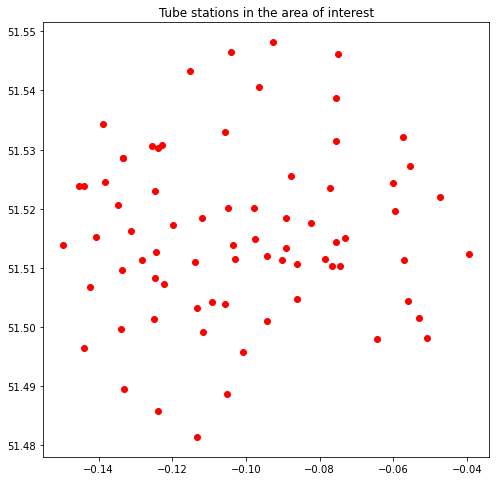

In [83]:
tstns_in_roi = gpd.overlay(tube_stnsgdf, 
                          buf4000_gdf.to_crs('epsg:4326'), 
                          how="intersection")
tstns_in_roi.plot(color='red')
plt.title('Tube stations in the area of interest')

In [84]:
print(f'There are {len(tstns_in_roi)} tube stations in the area of interest i.e yellow buffer zone')

There are 74 tube stations in the area of interest i.e yellow buffer zone


[c for c in tstns_in_poi.geometry[0].coords][0][:2][::-1]

folium.Marker?

Text(0.5, 1.0, 'Tube lines in the region of interest')

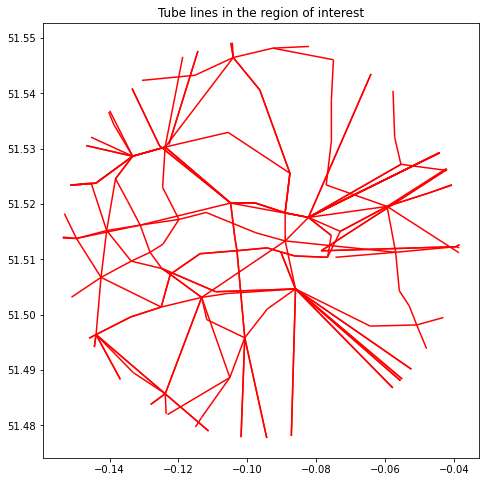

In [85]:
tlines_in_roi = gpd.overlay(tube_linesgdf, 
                          buf4000_gdf.to_crs('epsg:4326'), 
                          how="intersection")
tlines_in_roi.plot(color='red')
plt.title('Tube lines in the region of interest')

In [86]:
tstns_in_roi.head()

,Name,Description,geometry
0,Aldgate,<div>Zone 1</div> <div>EC3N 1AH</div> <div>Lat...,POINT Z (-0.07563 51.51434 0.00000)
1,Aldgate East,<div>Zone 1</div> <div>E1 7PT</div> <div>Latit...,POINT Z (-0.07300 51.51508 0.00000)
2,Angel,<div>Zone 1</div> <div>N1 8XB</div> <div>Latit...,POINT Z (-0.10558 51.53297 0.00000)
3,Bank,<div>Zone 1</div> <div>EC3V 3LA</div> <div>Lat...,POINT Z (-0.08900 51.51335 0.00000)
4,Barbican,<div>Zone 1</div> <div>EC1A 4JA</div> <div>Lat...,POINT Z (-0.09772 51.52022 0.00000)


In [87]:
for idx, tstn in enumerate([list(tstns_in_roi.geometry[index_no].coords) for index_no in tstns_in_roi.index]):
    location = list(tstn[0][:2][::-1]) #obtaining only long, lat
    
    # circle marker  'code adapted from https://stackoverflow.com/questions/60131314/folium-draw-star-marker'
    icon_circle = BeautifyIcon(
                  icon_shape='circle-dot', 
                  border_color='red', 
                  border_width=4.5,)
    folium.Marker(location, icon=icon_circle, tooltip=tstns_in_roi.loc[idx]['Name']).add_to(my_map)
    
    
    
my_map

In [88]:
for idx, pt in enumerate([list(tlines_in_roi.geometry[index_no].coords) for index_no in tlines_in_roi.index]):
    location = [pt[0][:2][::-1], pt[1][:2][::-1]] #obtaining only long, lat
    folium.PolyLine(location, color='red', tooltip=tlines_in_roi.loc[idx]['Name']).add_to(my_map)

my_map

------------------------------------------